In [1]:
import numpy as np
import matplotlib.pyplot as plt

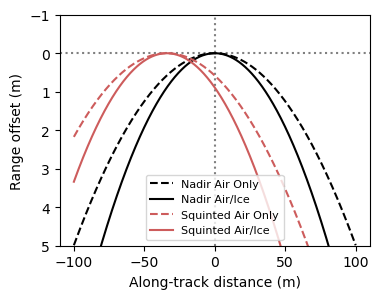

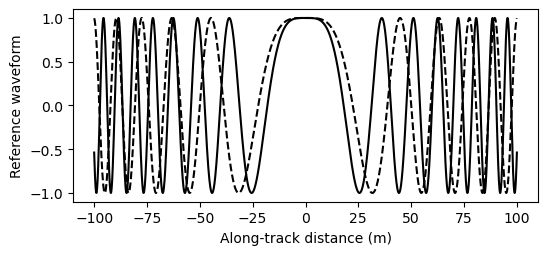

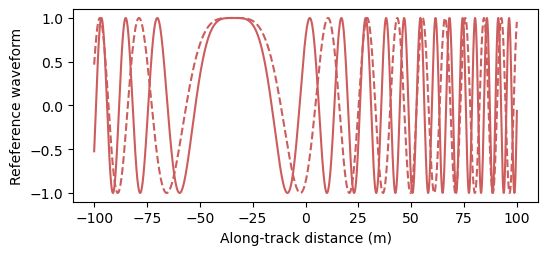

In [2]:
import numpy as np
from sar_geometry import *

# define the geometry
r0 = 1000.     # range to target at closest approach (assume x0 is 0)
h = 200 # height above ice surface
dx = .1        # x step
Xs = np.arange(-100.,100+dx,dx) # along-track distances within the synthetic aperture

# for a given squint angle (theta) find the depth in ice 
# and along-track distance (x0) from center of aperture to target
theta = 1e-10*np.pi/180. # divide by zero gives an error so give a small number
d, x0 = get_depth_dist(r0,h,theta)
# range offset within aperture - air only so simple geometry
R1_air = np.sqrt(r0**2.+(Xs-x0)**2.) - r0
# range offset within aperture - with ice so ray bending
R1_ice = SAR_aperture_raybend(r0, h, Xs, theta)

# again with non-zero squint
theta = -3.*np.pi/180.
d, x0 = get_depth_dist(r0,h,theta)
# range offset within aperture - air only so simple geometry
R2_air = np.sqrt((h+d)**2.+(Xs-x0)**2.) - h - d
# range offset within aperture - with ice so ray bending
R2_ice = SAR_aperture_raybend(r0, h, Xs, theta)
#```

#```{code-cell}
# Plot the range-offset function
plt.figure(figsize=(4,3))
plt.axhline(0,color='grey',ls=':')
plt.axvline(0,color='grey',ls=':')
plt.plot(Xs,R1_air,'k',ls='--',label='Nadir Air Only')
plt.plot(Xs,R1_ice,'k',label='Nadir Air/Ice')
plt.plot(Xs,R2_air,'indianred',ls='--',label='Squinted Air Only')
plt.plot(Xs,R2_ice,'indianred',label='Squinted Air/Ice')
plt.legend(fontsize=8)
plt.xlabel('Along-track distance (m)')
plt.ylabel('Range offset (m)')
plt.ylim(5,-1);
#```

#```{code-cell}
# Import functions from external scripts (see the note above)
from sar_functions import *
from supplemental import *

# Calculate and plot the matched filter for no squint
plt.figure(figsize=(6,2.5))
C = matched_filter(r2p(R1_air))
plt.plot(Xs,np.real(C),'k--')
C = matched_filter(r2p(R1_ice))
plt.plot(Xs,np.real(C),'k-')
plt.xlabel('Along-track distance (m)')
plt.ylabel('Reference waveform');
#```

#```{code-cell}
# Calculate and plot the matched filter with squint
plt.figure(figsize=(6,2.5))
C = matched_filter(r2p(R2_air))
plt.plot(Xs,np.real(C),'--',c='indianred')
C = matched_filter(r2p(R2_ice))
plt.plot(Xs,np.real(C),'-',c='indianred')
plt.xlabel('Along-track distance (m)')
plt.ylabel('Refeference waveform');
#```

In [3]:
hasattr(np.array([1.]),'__len__')

True

In [67]:
# instrument properties
fc = 150e6
c=3e8
L_a = 15. # antenna length
theta_beam = 0.866 * 3e8/(fc*L_a) # "half-power beamwidth" of the antenna with respect to its Length

# preallocate array
theta_sq = 0.
x_start = r0*np.sin(theta_sq-theta_beam)
x_end = r0*np.sin(theta_sq+theta_beam)
Xs = np.arange(x_start,x_end+1)
C_ref = np.nan*np.zeros((int(r0),len(Xs)),dtype=np.complex128)

for i,ri in enumerate(range(int(r0))):
    # get aperture extents
    x = ri*np.sin(theta_beam)
    xs = np.arange(-x,x+.01)
    # now calculate the reference function placed in the oversized array
    r = np.sqrt(ri**2+xs**2)-ri
    C = np.exp(-1j*4.*np.pi*fc*r/c)
    C_ref[i,len(Xs)//2-int(x):len(Xs)//2-int(x)+len(xs)] = C

    
# preallocate array
theta_sq = -3*np.pi/180.
x_start = -r0*np.sin(theta_sq+theta_beam)
x_end = -r0*np.sin(theta_sq-theta_beam)
x_extent = max(abs(x_start),abs(x_end))
Xs_sq = np.arange(-x_extent-1,x_extent+1)
C_sq = np.nan*np.zeros((int(r0),len(Xs_sq)),dtype=np.complex128)

print(x_start,x_end)

for i,ri in enumerate(range(int(r0))):
    # get aperture extents
    x_start = -ri*np.sin(theta_sq+theta_beam)
    x_end = -ri*np.sin(theta_sq-theta_beam)
    xs = np.arange(x_start,x_end+1)
    # now calculate the reference function placed in the oversized array
    r = np.sqrt(ri**2+xs**2)-ri
    C = np.exp(-1j*4.*np.pi*fc*r/c)
    #print(x_start,x_end,np.shape(C),np.shape(xs))
    C_sq[i,len(Xs_sq)//2+int(x_start):len(Xs_sq)//2+int(x_start)+len(xs)] = C

-63.06491066427329 167.03982625067522


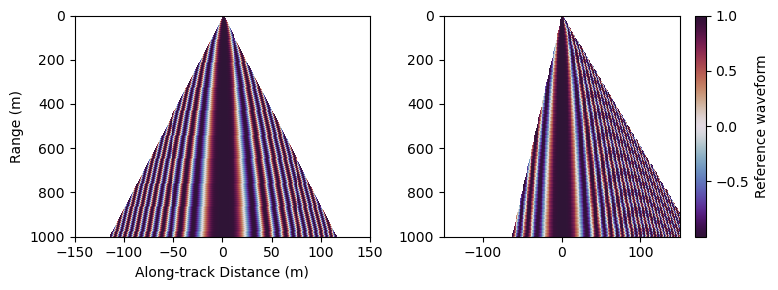

In [69]:
plt.figure(figsize=(8,3))

plt.subplot(121)
plt.pcolormesh(Xs,np.arange(r0),np.real(C_ref),cmap='twilight_shifted')
plt.ylim(r0,0)
plt.xlim(-150,150)
plt.xlabel('Along-track Distance (m)')
plt.ylabel('Range (m)');

plt.subplot(122)
plt.pcolormesh(Xs_sq,np.arange(r0),np.real(C_sq),cmap='twilight_shifted')
plt.ylim(r0,0)
plt.xlim(-150,150)
plt.colorbar(label='Reference waveform')
plt.tight_layout()